In [1]:
#%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import pandas as pd
import numpy as np
from Color import *
from operator import truediv, sub
from matplotlib.lines import Line2D

# Matplotlib font configuration
from MatplotlibFonts import *

# Change the font size
rcParams.update({"font.size": 15})
RESULT_DIR='../benchmarks/logs/'

In [2]:
from BenchmarkConfiguration import *
from Color import *
Compilers = [
    'uninstrumented',
    # 'cache_hints',
]

Benchmarks = [
    'coremark',
    'sha',
    'crc',
    'aes',
    'dijkstra',
    'picojpeg'
]

Configurations = [
    'clank',
    'nacho_naive',
    'nacho_pw',
    'nacho_clank',
    'prowl',
]

Stats = [
    'checkpoints','cycle count','last checkpoint','dirty ratio','cause'
]

CacheConfig = [ "-512-2-", "-256-2-", "-1024-2-", "-512-4-", "-256-4-", "-1024-4-"]

FinalStats = [
    'cache_miss', 
    'cache_hit', 
    'cache_read', 
    'cache_write', 
    'cache_cuckoo', 
    'cache_checkpoint', 
    'nvm_reads_no_cache', 
    'nvm_writes_no_cache', 
    'nvm_reads', 
    'nvm_writes', 
    'checkpoint', 
    'checkpoint_war', 
    'checkpoint_dirty', 
    'checkpoint_period', 
    'checkpoint_max_cycles', 
    'hints_given', 
    'max_dirty_ratio', 
    'cuckoo_iter',
    'cycle'
]




In [3]:
# Load the benchmarks
def load_cont_stats(bench, config, cache, compiler):
    file = RESULT_DIR + bench + "-" + compiler + "-run-" + config + cache
    return pd.read_csv(file + "cont").set_index("checkpoints")

def load_final_stats(bench, config, cache, compiler):
    file = RESULT_DIR + bench + "-" + compiler + "-run-" + config + cache
    return dict(pd.read_csv(file + "final", delimiter=":", header = None).values)

cont_stats = {}
final_stats = {}

for compiler in Compilers:
    cont_stats[compiler] = {}
    final_stats[compiler] = {} 
    for cache in CacheConfig:
        cont_stats[compiler][cache] = {}
        final_stats[compiler][cache] = {}
        for config in Configurations:
            # Prowl is not supported for any 4-way cache
            if cache in ["-256-4-", "-512-4-", "-1024-4-", "-8192-4-"] and config == "prowl":
                continue

            cont_stats[compiler][cache][config] = {}
            final_stats[compiler][cache][config] = {}
            for bench in Benchmarks:
                # For Clank store the same data for all values
                if config == 'clank':
                    final_stats[compiler][cache][config][bench] = dict(pd.read_csv(RESULT_DIR + bench + "-" + compiler + "-run-clank-final", delimiter=":", header = None).values)
                    cont_stats[compiler][cache][config][bench] =  pd.read_csv(RESULT_DIR + bench + "-" + compiler + "-run-clank-cont").set_index("checkpoints")               
                    continue
                cont_stats[compiler][cache][config][bench] = load_cont_stats(bench, config, cache, compiler)
                final_stats[compiler][cache][config][bench] = load_final_stats(bench, config, cache, compiler)

In [4]:
def setupFigure(rows, cols, xShare=True, yShare=True, figuresize=(10,7)):
    fig, ax_np = plt.subplots(nrows=rows, ncols=cols, sharex=xShare, figsize=figuresize, sharey=yShare);

    ax = []
    if (rows == 1 or cols == 1):
        if rows*cols == 1:
            ax = ax_np
            return (fig, ax)
        for i in range(rows*cols):
            ax.append(ax_np[i])
    else:
        for i in range(rows):
            for j in range(cols):
                ax.append(ax_np[i][j])

    return (fig, ax)

In [5]:
def fetchNormalizedValues(compiler, cache_config_used, config, requested_stats):
    normalizing_factor = []
    for bmark in final_stats[compiler][cache_config_used][config]:
        val = 0
        for stat in requested_stats:
            val = val + final_stats[compiler][cache_config_used][config][bmark][stat]
        
        normalizing_factor.append(val)

    return normalizing_factor

In [6]:
prowlCycleValues = []
nachoCycleValues = []
meanImprovement = []
compiler = 'uninstrumented'
for cache in ['-256-2-']:
        prowlCycleValues = fetchNormalizedValues(compiler, cache, 'prowl', ['cycle'])
        nachoCycleValues = fetchNormalizedValues(compiler, cache, 'nacho_pw', ['cycle'])
        diff = list(map(sub, prowlCycleValues, nachoCycleValues))
        diff = np.array(diff)
        diff = diff * 100 / np.array(prowlCycleValues)
        meanImprovement.append(diff.mean())

meanImprovement

[58.40821883947893]

## Execution time (CPU cycles) for different systems

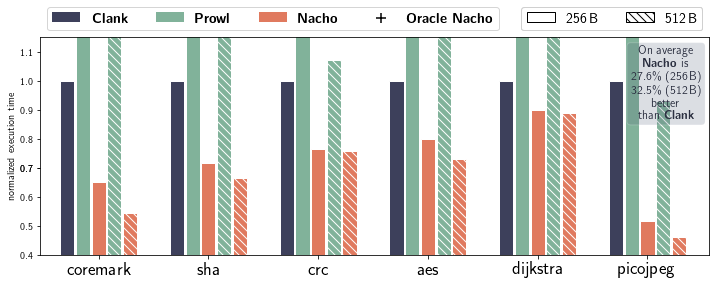

In [10]:
barsToPlot = {
                'config':['clank', 'prowl', 'nacho_pw'],
                'cache':['-256-2-', '-512-2-'],
                'bench':Benchmarks,
                'stats':['cycle'],
                'all_config':[('clank', '-256-2-'),
                            #   ('nacho-naive', '-256-2-'),
                            #   ('nachi-naive', '-512-2-'),
                              ('prowl', '-256-2-'),
                              ('prowl', '-512-2-'),
                              ('nacho_pw', '-256-2-'),
                              ('nacho_pw', '-512-2-'),]
            }

normalizeTo = "clank"

fig, ax = setupFigure(1, 1, figuresize=(12,4))
X = np.arange(len(Benchmarks))
stepSize = 1 / (len(barsToPlot['all_config']) + 2) 

gapThreshold = 1.15
gapStart = 1.12
ax.set_ylim(ymin=0.4, ymax=gapThreshold)
ax.set_xlim(-0.25,5.85);
ax.margins(x=0);
# ax.spines['right'].set_visible(False);
# ax.spines['top'].set_visible(False);
ax.set_xticks(X + stepSize * (len(barsToPlot['all_config']) - 1) / 2, Benchmarks, fontsize=18);
ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.7, 0.9, 0.8, 1.0, 1.1], fontsize=14)

step = 0
lineWidth = 0.1
clankDoneOnce = False;

compiler = 'uninstrumented'

# For each config
for cache in barsToPlot['cache']:

    # For different colors for configs
    idxCache = barsToPlot['cache'].index(cache)

    #for each cache
    for config in barsToPlot['config']:

        if config == 'clank':
            if clankDoneOnce is True:
                continue

            clankDoneOnce = True

        # For different colors for configs
        idxConfig = barsToPlot['config'].index(config)

        # The number of grouped plots are equal to the number of benchmarks
        toPlot = np.zeros(len(barsToPlot['bench']))
        
        # Get normalized value for the stats
        normalizedStat = fetchNormalizedValues(compiler, cache, normalizeTo, barsToPlot['stats'])

        # For each stack in the bar plot - stats
        for stats in barsToPlot['stats']:
            currStats = []

            # For different colors for stacked stats
            idxStat = barsToPlot['stats'].index(stats)
            
            # For each bmark
            for bench in barsToPlot['bench']:
                currStats.append(final_stats[compiler][cache][config][bench][stats])

            # Normalize the stats
            currStats = list(map(truediv, currStats, normalizedStat))

            # plot the stacked bar
            line = ax.bar(X + step,
                            currStats,
                            bottom = toPlot,
                            linewidth = 1,
                            joinstyle = 'miter',
                            hatch = patterns[idxCache] * 3,
                            color = ColorScheme[config],
                            alpha = 1,
                            edgecolor = 'white',
                            width = 4.5 * stepSize / 5)

            # increment the stack
            toPlot = toPlot + currStats

            if config == 'nacho-pw':
                markersToPlace = fetchNormalizedValues(compiler, cache, "nacho_clank", barsToPlot['stats'])
                markersToPlace = list(map(truediv, markersToPlace, normalizedStat))
                idx = 0
                for val in markersToPlace:
                    ann = plt.scatter(X[idx] + step, val, color='black',
                                      linewidths=1, marker="+", s=80)
                    idx = idx + 1

        # if config != 'clank':
        #     hLineForIdealCase = fetchNormalizedValues(cache, "nacho-clank", barsToPlot['stats'])
        #     hLineForIdealCase = list(map(truediv, hLineForIdealCase, normalizedStat))
        #     line = ax.bar(X + step,
        #                     hLineForIdealCase,
        #                     linewidth = 1,
        #                     joinstyle = 'miter',
        #                     color = 'white',
        #                     alpha = 0.4,
        #                     edgecolor = None,
        #                     width = 4.5 * stepSize / 5)

        # Separating each bmark
        step = step + stepSize

# Calculate the improvement percentages
prowlCycleValues = []
nachoCycleValues = []
meanImprovement = []
for cache in barsToPlot['cache']:
        prowlCycleValues = fetchNormalizedValues(compiler, cache, 'clank', ['cycle'])
        nachoCycleValues = fetchNormalizedValues(compiler, cache, 'nacho_pw', ['cycle'])
        diff = list(map(sub, prowlCycleValues, nachoCycleValues))
        diff = np.array(diff)
        diff = diff * 100 / np.array(prowlCycleValues)
        meanImprovement.append(diff.mean())

props = dict(boxstyle='round', facecolor=ColorName['Coral'], alpha=0.2, edgecolor='white')
text = "On average\n\\textbf{Nacho} is\n" + str(meanImprovement[0].round(1)) + "\% (256\,B)\n" + \
       str(meanImprovement[1].round(1)) + "\% (512\,B)\nbetter \nthan \\textbf{Clank}"

ann = plt.annotate(text,
                   xy=(5.455, 0.99), xytext=(0,0),
                   fontsize=12,
                   color=ColorName['Deep grey'],
                   horizontalalignment='center', verticalalignment='center',
                   xycoords=('data'), textcoords='offset points',
                   bbox=props,
                   annotation_clip=False)

# fig.add_artist(ann)

# For the legend
label1 = ['\\textbf{Clank}', '\\textbf{Prowl}','\\textbf{Nacho}', '\\textbf{Oracle Nacho}']
label2 = ['256\\,B', '512\\,B']
label3 = ['Ideal Nacho']

n=[];
for i in barsToPlot['config']:
    n.append(ax.bar(0, 0, color=ColorScheme[i]))

n.append(plt.scatter(0, 0, color='black', linewidths=1.5, marker="+", s=120))
l1 = plt.legend(n, label1, loc='lower left', ncol=len(n),
                bbox_to_anchor = (0, 1), fancybox=True, fontsize=14);

ax.add_artist(l1)

n=[];
for i in range(len(barsToPlot['cache'])):
    n.append(ax.bar(0, 0, hatch=patterns[i]*3, color='white', edgecolor='black'))

l2 = plt.legend(n, label2, loc='lower right', ncol=len(n),
                bbox_to_anchor = (1, 1), fancybox=True, fontsize=14);

ax.add_artist(l2)

# n = [plt.scatter(0, 0, color=ColorName['Mandarin'], linewidths=3, marker="d")]
# l3 = plt.legend(n, label3, loc='upper right',
#                 bbox_to_anchor = (1.15, 0.68), fancybox=True, fontsize=14)


# ax.set_title("Execution time (CPU cycles) for different systems")
ax.set_ylabel("normalized execution time")
print();
fig.savefig('plots/execution-time.pdf', bbox_inches='tight');

## Desgin space exploration of cache configuration with execution time (CPU cycles)

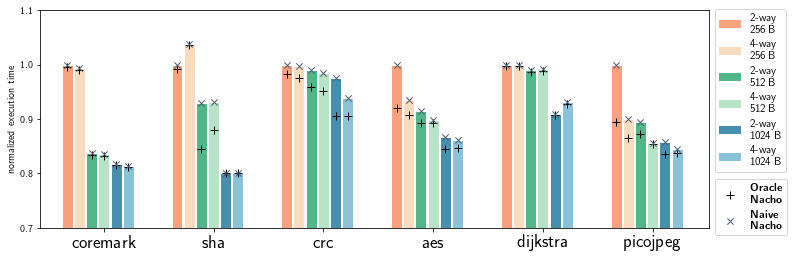

In [11]:
barsToPlot = {
                'config':['nacho_pw'],
                'cache':['-256-2-', '-256-4-', '-512-2-', '-512-4-', '-1024-2-', '-1024-4-'],
                'bench':Benchmarks,
                'stats':['cycle'],
                'all_config':[('clank', '-256-2-'),
                              ('nacho_pw', '-256-2-'),
                              ('nacho_pw', '-256-4-'),
                              ('nacho_pw', '-512-2-'),
                              ('nacho_pw', '-512-4-'),
                              ('nacho_pw', '-1024-2-'),
                              ('nacho_pw', '-1024-4-'),]
            }

fig, ax = setupFigure(1, 1, figuresize=(12,4))
X = np.arange(len(Benchmarks))
stepSize = 1 / (len(barsToPlot['all_config']) + 2) 


ax.set_ylim(ymin=0.75, ymax=1.07)
ax.set_xlim(-0.25,5.85);
ax.margins(x=0);
# ax.spines['right'].set_visible(False);
# ax.spines['top'].set_visible(False);
ax.set_xticks(X + stepSize * (len(barsToPlot['all_config']) - 1) / 2, Benchmarks, fontsize=18);
ax.set_yticks([0.7, 0.9, 0.8, 1.0, 1.1], fontsize=14)
ax.set_ylabel("normalized execution time")

step = 0
lineWidth = 0.1

clankDoneOnce = False;

# For each config
for cache in barsToPlot['cache']:

    # For different colors for configs
    idxCache = barsToPlot['cache'].index(cache)

    #for each cache
    for config in barsToPlot['config']:

        if config == 'clank':
            if clankDoneOnce is True:
                continue

            clankDoneOnce = True

        # For different colors for configs
        idxConfig = barsToPlot['config'].index(config)

        # The number of grouped plots are equal to the number of benchmarks
        toPlot = np.zeros(len(barsToPlot['bench']))
        
        # Get normalized value for the stats
        normalizedStat = fetchNormalizedValues(compiler, '-256-2-', config, barsToPlot['stats'])

        # For each stack in the bar plot - stats
        for stats in barsToPlot['stats']:
            currStats = []

            # For different colors for stacked stats
            idxStat = barsToPlot['stats'].index(stats)
            
            # For each bmark
            for bench in barsToPlot['bench']:
                currStats.append(final_stats[compiler][cache][config][bench][stats])
            
            # Normalize the stats
            currStats = list(map(truediv, currStats, normalizedStat))

            # plot the stacked bar
            line = ax.bar(X + step,
                            currStats,
                            bottom = toPlot,
                            linewidth = 1,
                            joinstyle = 'miter',
                            # hatch = patterns[idxCache] * 3,
                            color = ColorShades[idxCache],
                            alpha = 1,
                            edgecolor = 'white',
                            width = 4.5 * stepSize / 5)

            # increment the stack
            toPlot = toPlot + currStats

            if config == 'nacho_pw':
                markersToPlace = fetchNormalizedValues(compiler, cache, "nacho_clank", barsToPlot['stats'])
                markersToPlace = list(map(truediv, markersToPlace, normalizedStat))
                idx = 0
                for val in markersToPlace:
                    ann = plt.scatter(X[idx] + step, val, color='black',
                                      linewidths=1, marker="+", s=80)
                    idx = idx + 1

                markersToPlace = fetchNormalizedValues(compiler, cache, "nacho_naive", barsToPlot['stats'])
                markersToPlace = list(map(truediv, markersToPlace, normalizedStat))
                idx = 0
                for val in markersToPlace:
                    ann = plt.scatter(X[idx] + step, val, color=ColorName['Coral'],
                                      linewidths=1, marker="x", s=40)
                    idx = idx + 1

        # if config != 'clank':
        #     hLineForIdealCase = fetchNormalizedValues(cache, "nacho-clank", barsToPlot['stats'])
        #     hLineForIdealCase = list(map(truediv, hLineForIdealCase, normalizedStat))
        #     line = ax.bar(X + step,
        #                     hLineForIdealCase,
        #                     linewidth = 1,
        #                     joinstyle = 'miter',
        #                     color = 'white',
        #                     alpha = 0.3,
        #                     edgecolor = None,
        #                     width = 4.5 * stepSize / 5)

        # Separating each bmark
        step = step + stepSize

# For the legend
label1 = ['\\textbf{Oracle}\n\\textbf{Nacho}', '\\textbf{Naive}\n\\textbf{Nacho}']
label2 = ['2-way\n256\\,B', '4-way\n256\\,B', '2-way\n512\\,B', '4-way\n512\\,B', '2-way\n1024\\,B', '4-way\n1024\\,B',]
label3 = ['Ideal Nacho']

n=[];
n.append(plt.scatter(0,0, color='black',
                                      linewidths=1, marker="+", s=80))
n.append(plt.scatter(0,0, color=ColorName['Coral'],
                                      linewidths=1, marker="x", s=40))

l1 = plt.legend(n, label1, loc='upper left',
                bbox_to_anchor = (1, 0.25), fancybox=True, fontsize=11);

ax.add_artist(l1)

n=[];
for i in range(len(barsToPlot['cache'])):
    n.append(ax.bar(0, 0, color=ColorShades[i]))


l2 = plt.legend(n, label2, loc='upper left',
                bbox_to_anchor = (1, 1.03), fancybox=True, fontsize=11);

# ax.set_title("Desgin space exploration of cache configuration with execution time (CPU cycles)")
print();
fig.savefig('plots/design-space.pdf', bbox_inches='tight');

## Number of checkpoints created for different systems

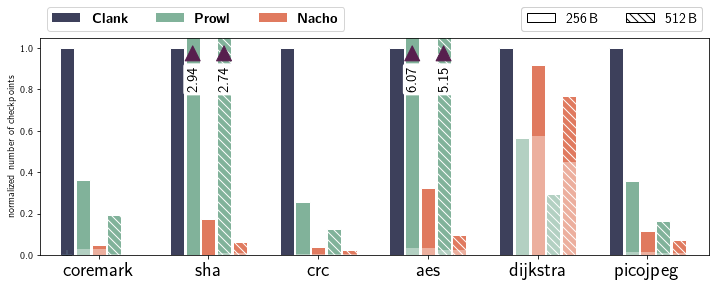

In [12]:
barsToPlot = {
                'config':['clank', 'prowl', 'nacho_pw'],
                'cache':['-256-2-', '-512-2-'],
                'bench':Benchmarks,
                'stats':['checkpoint'],
                'all_config':[('clank', '-256-2-'),
                              ('prowl', '-256-2-'),
                              ('prowl', '-512-2-'),
                              ('nacho_pw', '-256-2-'),
                              ('nacho_pw', '-512-2-'),]
            }

normalizeTo = "clank"

fig, ax = setupFigure(1, 1, figuresize=(12,4))
X = np.arange(len(Benchmarks))
stepSize = 1 / (len(barsToPlot['all_config']) + 2) 

gapThreshold = 1.05
gapStart = 1.02
ax.set_ylim(ymax=gapThreshold)
ax.set_xlim(-0.25,5.85);
ax.margins(x=0);
# ax.spines['right'].set_visible(False);
# ax.spines['top'].set_visible(False);
ax.set_xticks(X + stepSize * (len(barsToPlot['all_config']) - 1) / 2, Benchmarks, fontsize=20);
# ax.set_yticks([0.5, 0.75, 1.0])
ax.set_ylabel("normalized number of checkpoints")

step = 0
lineWidth = 0.1
clankDoneOnce = False;

# For each config
for cache in barsToPlot['cache']:

    # For different colors for configs
    idxCache = barsToPlot['cache'].index(cache)

    #for each cache
    for config in barsToPlot['config']:

        if config == 'clank':
            if clankDoneOnce is True:
                continue

            clankDoneOnce = True

        # For different colors for configs
        idxConfig = barsToPlot['config'].index(config)

        # The number of grouped plots are equal to the number of benchmarks
        toPlot = np.zeros(len(barsToPlot['bench']))
        
        # Get normalized value for the stats
        normalizedStat = fetchNormalizedValues(compiler, cache, normalizeTo, barsToPlot['stats'])

        # For each stack in the bar plot - stats
        for stats in barsToPlot['stats']:
            currStats = []

            # For different colors for stacked stats
            idxStat = barsToPlot['stats'].index(stats)
            
            # For each bmark
            for bench in barsToPlot['bench']:
                currStats.append(final_stats[compiler][cache][config][bench][stats])
            
            # Normalize the stats
            currStats = list(map(truediv, currStats, normalizedStat))

            # plot the stacked bar
            line = ax.bar(X + step,
                            currStats,
                            bottom = toPlot,
                            linewidth = 1,
                            joinstyle = 'miter',
                            hatch = patterns[idxCache] * 3,
                            color = ColorScheme[config],
                            alpha = 1,
                            edgecolor = 'white',
                            width = 4.5 * stepSize / 5)

            # increment the stack
            toPlot = toPlot + currStats

            idx = 0
            for val in currStats:
                if (val > gapThreshold):
                    plt.text(X[idx] + step - 0.058, gapStart - gapThreshold/4.77,
                             str(round(val, 2)),
                             rotation=90,
                             color='black',
                             fontsize=15,
                             bbox=dict(facecolor='white', edgecolor='None', boxstyle='round, pad=0.2'))
                    ann = plt.annotate("",
                        rotation=90,
                        xy = (X[idx] + step, gapStart),
                        xytext = (0,-18),
                        weight='bold',
                        color = ColorName['Coral'],
                        horizontalalignment = 'center',
                        verticalalignment = 'center',
                        xycoords = ('data'), textcoords='offset points',
                        annotation_clip=False,
                        arrowprops = dict(arrowstyle="simple",
                                          mutation_scale=30,
                                          facecolor=ColorName['Purple'],
                                          edgecolor=ColorName['Purple'],
                                          shrinkB=2, lw=1),
                        )
                idx = idx + 1

        if config != 'clank':
            hLineForIdealCase = fetchNormalizedValues(compiler, cache, "nacho_clank", barsToPlot['stats'])
            hLineForIdealCase = list(map(truediv, hLineForIdealCase, normalizedStat))
            line = ax.bar(X + step,
                            hLineForIdealCase,
                            linewidth = 1,
                            joinstyle = 'miter',
                            color = 'white',
                            alpha = 0.4,
                            edgecolor = None,
                            width = 4.5 * stepSize / 5)

        # Separating each bmark
        step = step + stepSize

# # Calculate the improvement percentages
# prowlCycleValues = []
# nachoCycleValues = []
# meanImprovement = []
# for cache in barsToPlot['cache']:
#         prowlCycleValues = fetchNormalizedValues(cache, 'clank', ['checkpoint'])
#         nachoCycleValues = fetchNormalizedValues(cache, 'nacho-pw', ['checkpoint'])
#         diff = list(map(sub, prowlCycleValues, nachoCycleValues))
#         diff = np.array(diff)
#         diff = diff * 100 / np.array(prowlCycleValues)
#         meanImprovement.append(diff.mean())

# props = dict(boxstyle='round', facecolor=ColorName['Coral'], alpha=0.2, edgecolor='white')
# text = "On average\n\\textbf{Nacho} is\n" + str(meanImprovement[0].round(1)) + "\% (256\\,B)\n" + \
#        str(meanImprovement[1].round(1)) + "\% (512\\,B)\nbetter than\n\\textbf{Clank}"

# ann = plt.annotate(text,
#                    xy=(5.455, 0.8345), xytext=(0,0),
#                    fontsize=12,
#                    color=ColorName['Deep grey'],
#                    horizontalalignment='center', verticalalignment='center',
#                    xycoords=('data'), textcoords='offset points',
#                    bbox=props,
#                    annotation_clip=False)

# fig.add_artist(ann)

# For the legend
label1 = ['\\textbf{Clank}', '\\textbf{Prowl}','\\textbf{Nacho}']
label2 = ['256\\,B', '512\\,B']

# n=[];
# for i in barsToPlot['config']:
#     n.append(ax.bar(0, 0, color=ColorScheme[i]))

# l1 = plt.legend(n, label1, loc='upper right',
#                 bbox_to_anchor = (1.15, 1), fancybox=True, fontsize=14);

# ax.add_artist(l1)

# n=[];
# for i in range(len(barsToPlot['cache'])):
#     n.append(ax.bar(0, 0, hatch=patterns[i]*3, color='white', edgecolor='black'))


# l2 = plt.legend(n, label2, loc='upper right',
#                 bbox_to_anchor = (1.145, 0.68), fancybox=True, fontsize=14);


n=[];
for i in barsToPlot['config']:
    n.append(ax.bar(0, 0, color=ColorScheme[i]))

n.append(plt.scatter(0, 0, color=ColorScheme['nacho_clank'], linewidths=1.5, marker="+", s=120))
l1 = plt.legend(n, label1, loc='lower left', ncol=len(n),
                bbox_to_anchor = (0, 1), fancybox=True, fontsize=14);

ax.add_artist(l1)

n=[];
for i in range(len(barsToPlot['cache'])):
    n.append(ax.bar(0, 0, hatch=patterns[i]*3, color='white', edgecolor='black'))

l2 = plt.legend(n, label2, loc='lower right', ncol=len(n),
                bbox_to_anchor = (1, 1), fancybox=True, fontsize=14);

ax.add_artist(l2)

# ax.set_title("Number of checkpoints created for different systems")

print();
fig.savefig('plots/checkpoints.pdf', bbox_inches='tight');

## Volatile Memory accesses for different systems

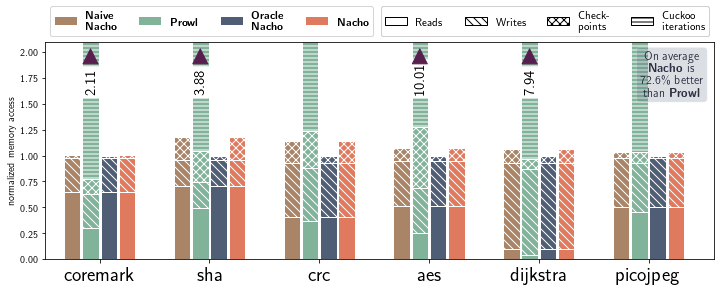

In [13]:
barsToPlot = {
                'config':['nacho_naive', 'prowl', 'nacho_clank', 'nacho_pw'],
                'cache':['-512-2-'],
                'bench':Benchmarks,
                'stats':['cache_read', 'cache_write', 'cache_checkpoint', 'cache_cuckoo'],
                # 'stats':['cycle'],
                'all_config':[
                              ('nacho_naive', '-512-2-'),
                              ('prowl', '-512-2-'),
                              ('nacho_clank', '-512-2-'),
                              ('nacho_pw', '-512-2-'),]
            }

normalizeTo = "nacho_clank"

fig, ax = setupFigure(1, 1, figuresize=(12,4))
X = np.arange(len(Benchmarks))
stepSize = 1 / (len(barsToPlot['all_config']) + 2) 

gapThreshold = 2.1
gapStart = 2.05
ax.set_ylim(ymax=gapThreshold)
ax.set_xlim(-0.25,5.85);
ax.margins(x=0);
# ax.spines['right'].set_visible(False);
# ax.spines['top'].set_visible(False);
ax.set_xticks(X + stepSize * (len(barsToPlot['all_config']) - 1) / 2, Benchmarks, fontsize=20);
# ax.set_yticks([0.5, 0.75, 1.0])
ax.set_ylabel("normalized memory access")
step = 0
lineWidth = 0.1
clankDoneOnce = False;

# For each config
for cache in barsToPlot['cache']:

    # For different colors for configs
    idxCache = barsToPlot['cache'].index(cache)

    #for each cache
    for config in barsToPlot['config']:

        if config == 'clank':
            if clankDoneOnce is True:
                continue

            clankDoneOnce = True

        # For different colors for configs
        idxConfig = barsToPlot['config'].index(config)

        # The number of grouped plots are equal to the number of benchmarks
        toPlot = np.zeros(len(barsToPlot['bench']))
        
        # Get normalized value for the stats
        normalizedStat = fetchNormalizedValues(compiler, cache, normalizeTo, barsToPlot['stats'])

        # For each stack in the bar plot - stats
        for stats in barsToPlot['stats']:
            currStats = []

            # For different colors for stacked stats
            idxStat = barsToPlot['stats'].index(stats)
            
            # For each bmark
            for bench in barsToPlot['bench']:
                currStats.append(final_stats[compiler][cache][config][bench][stats])
            
            # Normalize the stats
            currStats = list(map(truediv, currStats, normalizedStat))

            # plot the stacked bar
            line = ax.bar(X + step,
                            currStats,
                            bottom = toPlot,
                            linewidth = 1,
                            joinstyle = 'miter',
                            hatch = patterns[idxStat] * 3,
                            color = ColorScheme[config],
                            alpha = 1,
                            edgecolor = 'white',
                            width = 4.5 * stepSize / 5)

            # increment the stack
            toPlot = toPlot + currStats

            idx = 0
            for val in currStats:
                if (val > gapThreshold):
                    plt.text(X[idx] + step - 0.058, gapStart - gapThreshold/4.77,
                             str(round(val, 2)),
                             rotation=90,
                             color='black',
                             fontsize=15,
                             bbox=dict(facecolor='white', edgecolor='None', boxstyle='round, pad=0.2'))
                    ann = plt.annotate("",
                        rotation=90,
                        xy = (X[idx] + step, gapStart),
                        xytext = (0,-18),
                        weight='bold',
                        color = ColorName['Coral'],
                        horizontalalignment = 'center',
                        verticalalignment = 'center',
                        xycoords = ('data'), textcoords='offset points',
                        annotation_clip=False,
                        arrowprops = dict(arrowstyle="simple",
                                          mutation_scale=30,
                                          facecolor=ColorName['Purple'],
                                          edgecolor=ColorName['Purple'],
                                          shrinkB=2, lw=1),
                        )
                idx = idx + 1

        # if config != 'clank':
        #     hLineForIdealCase = fetchNormalizedValues(cache, "nacho-clank", barsToPlot['stats'])
        #     hLineForIdealCase = list(map(truediv, hLineForIdealCase, normalizedStat))
        #     line = ax.bar(X + step,
        #                     hLineForIdealCase,
        #                     linewidth = 1,
        #                     joinstyle = 'miter',
        #                     color = 'white',
        #                     alpha = 0.4,
        #                     edgecolor = None,
        #                     width = 4.5 * stepSize / 5)

        # Separating each bmark
        step = step + stepSize

# Calculate the improvement percentages
prowlCycleValues = []
nachoCycleValues = []
meanImprovement = []
for cache in barsToPlot['cache']:
        prowlCycleValues = fetchNormalizedValues(compiler, cache, 'prowl', barsToPlot['stats'])
        nachoCycleValues = fetchNormalizedValues(compiler, cache, 'nacho_pw', barsToPlot['stats'])
        diff = list(map(sub, prowlCycleValues, nachoCycleValues))
        diff = np.array(diff)
        diff = diff * 100 / np.array(prowlCycleValues)
        meanImprovement.append(diff.mean())

props = dict(boxstyle='round', facecolor=ColorName['Coral'], alpha=0.2, edgecolor='white')
text = "On average\n\\textbf{Nacho} is\n" + str(meanImprovement[0].round(1)) + "\% better\nthan \\textbf{Prowl}"

ann = plt.annotate(text,
                   xy=(5.462, 1.78), xytext=(0,0),
                   fontsize=12,
                   color=ColorName['Deep grey'],
                   horizontalalignment='center', verticalalignment='center',
                   xycoords=('data'), textcoords='offset points',
                   bbox=props,
                   annotation_clip=False)

# fig.add_artist(ann)

# For the legend
label1 = ['\\textbf{Naive}\n\\textbf{Nacho}', '\\textbf{Prowl}', '\\textbf{Oracle}\n\\textbf{Nacho}', '\\textbf{Nacho}']
label2 = ['Reads', 'Writes', 'Check-\npoints', 'Cuckoo\niterations']

# n=[];
# for i in barsToPlot['config']:
#     n.append(ax.bar(0, 0, color=ColorScheme[i]))

# l1 = plt.legend(n, label1, loc='upper right',
#                 bbox_to_anchor = (1.15, 1), fancybox=True, fontsize=14);

# ax.add_artist(l1)

# n=[];
# for i in range(len(barsToPlot['stats'])):
#     n.append(ax.bar(0, 0, hatch=patterns[i]*3, color='white', edgecolor='black'))


# l2 = plt.legend(n, label2, loc='upper right',
#                 bbox_to_anchor = (1.155, 0.45), fancybox=True, fontsize=14);


n=[];
for i in barsToPlot['config']:
    n.append(ax.bar(0, 0, color=ColorScheme[i]))

l1 = plt.legend(n, label1, loc='lower left', ncol=len(n),
                bbox_to_anchor = (0, 1), fancybox=True, fontsize=13, prop={'size': 11});

ax.add_artist(l1)

n=[];
for i in range(len(barsToPlot['stats'])):
    n.append(ax.bar(0, 0, hatch=patterns[i]*3, color='white', edgecolor='black'))

l2 = plt.legend(n, label2, loc='lower right', ncol=len(n),
                bbox_to_anchor = (1, 1), fancybox=True, fontsize=13, prop={'size': 11});

ax.add_artist(l2)


print();
fig.savefig('plots/volatile-access.pdf', bbox_inches='tight');

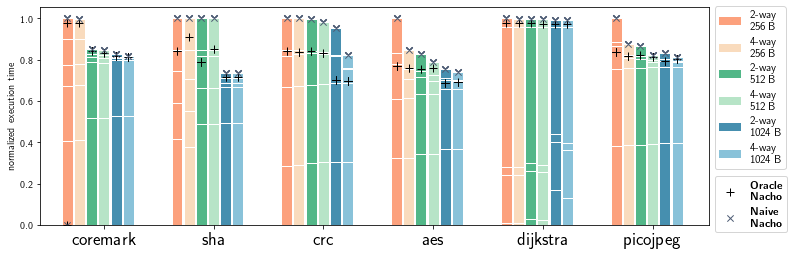

In [11]:
barsToPlot = {
                'config':['nacho_pw'],
                'cache':['-256-2-', '-256-4-', '-512-2-', '-512-4-', '-1024-2-', '-1024-4-'],
                'bench':Benchmarks,
                'stats':['cache_read', 'cache_write', 'cache_checkpoint', 'cache_cuckoo', 'nvm_reads', 'nvm_writes'],
                'all_config':[('clank', '-256-2-'),
                              ('nacho_pw', '-256-2-'),
                              ('nacho_pw', '-256-4-'),
                              ('nacho_pw', '-512-2-'),
                              ('nacho_pw', '-512-4-'),
                              ('nacho_pw', '-1024-2-'),
                              ('nacho_pw', '-1024-4-'),]
            }

fig, ax = setupFigure(1, 1, figuresize=(12,4))
X = np.arange(len(Benchmarks))
stepSize = 1 / (len(barsToPlot['all_config']) + 2) 


ax.set_ylim(auto=True)
ax.set_xlim(-0.25,5.85);
ax.margins(x=0);
# ax.spines['right'].set_visible(False);
# ax.spines['top'].set_visible(False);
ax.set_xticks(X + stepSize * (len(barsToPlot['all_config']) - 1) / 2, Benchmarks, fontsize=18);
# ax.set_yticks([0.7, 0.9, 0.8, 1.0, 1.1], fontsize=14)
ax.set_ylabel("normalized execution time")

step = 0
lineWidth = 0.1

clankDoneOnce = False;

# For each config
for cache in barsToPlot['cache']:

    # For different colors for configs
    idxCache = barsToPlot['cache'].index(cache)

    #for each cache
    for config in barsToPlot['config']:

        if config == 'clank':
            if clankDoneOnce is True:
                continue

            clankDoneOnce = True

        # For different colors for configs
        idxConfig = barsToPlot['config'].index(config)

        # The number of grouped plots are equal to the number of benchmarks
        toPlot = np.zeros(len(barsToPlot['bench']))
        
        # Get normalized value for the stats
        normalizedStat = fetchNormalizedValues(compiler, '-256-2-', config, barsToPlot['stats'])

        # For each stack in the bar plot - stats
        for stats in barsToPlot['stats']:
            currStats = []

            # For different colors for stacked stats
            idxStat = barsToPlot['stats'].index(stats)
            
            # For each bmark
            for bench in barsToPlot['bench']:
                currStats.append(final_stats[compiler][cache][config][bench][stats])
            
            # Normalize the stats
            currStats = list(map(truediv, currStats, normalizedStat))

            # plot the stacked bar
            line = ax.bar(X + step,
                            currStats,
                            bottom = toPlot,
                            linewidth = 1,
                            joinstyle = 'miter',
                            # hatch = patterns[idxCache] * 3,
                            color = ColorShades[idxCache],
                            alpha = 1,
                            edgecolor = 'white',
                            width = 4.5 * stepSize / 5)

            # increment the stack
            toPlot = toPlot + currStats

            if config == 'nacho_pw':
                markersToPlace = fetchNormalizedValues(compiler, cache, "nacho_clank", barsToPlot['stats'])
                markersToPlace = list(map(truediv, markersToPlace, normalizedStat))
                idx = 0
                for val in markersToPlace:
                    ann = plt.scatter(X[idx] + step, val, color='black',
                                      linewidths=1, marker="+", s=80)
                    idx = idx + 1

                markersToPlace = fetchNormalizedValues(compiler, cache, "nacho_naive", barsToPlot['stats'])
                markersToPlace = list(map(truediv, markersToPlace, normalizedStat))
                idx = 0
                for val in markersToPlace:
                    ann = plt.scatter(X[idx] + step, val, color=ColorName['Coral'],
                                      linewidths=1, marker="x", s=40)
                    idx = idx + 1

        # if config != 'clank':
        #     hLineForIdealCase = fetchNormalizedValues(cache, "nacho-clank", barsToPlot['stats'])
        #     hLineForIdealCase = list(map(truediv, hLineForIdealCase, normalizedStat))
        #     line = ax.bar(X + step,
        #                     hLineForIdealCase,
        #                     linewidth = 1,
        #                     joinstyle = 'miter',
        #                     color = 'white',
        #                     alpha = 0.3,
        #                     edgecolor = None,
        #                     width = 4.5 * stepSize / 5)

        # Separating each bmark
        step = step + stepSize

# For the legend
label1 = ['\\textbf{Oracle}\n\\textbf{Nacho}', '\\textbf{Naive}\n\\textbf{Nacho}']
label2 = ['2-way\n256\\,B', '4-way\n256\\,B', '2-way\n512\\,B', '4-way\n512\\,B', '2-way\n1024\\,B', '4-way\n1024\\,B',]
label3 = ['Ideal Nacho']

n=[];
n.append(plt.scatter(0,0, color='black',
                                      linewidths=1, marker="+", s=80))
n.append(plt.scatter(0,0, color=ColorName['Coral'],
                                      linewidths=1, marker="x", s=40))

l1 = plt.legend(n, label1, loc='upper left',
                bbox_to_anchor = (1, 0.25), fancybox=True, fontsize=11);

ax.add_artist(l1)

n=[];
for i in range(len(barsToPlot['cache'])):
    n.append(ax.bar(0, 0, color=ColorShades[i]))


l2 = plt.legend(n, label2, loc='upper left',
                bbox_to_anchor = (1, 1.03), fancybox=True, fontsize=11);

# ax.set_title("Desgin space exploration of cache configuration with execution time (CPU cycles)")
print();
fig.savefig('plots/design-space-non-volatile.pdf', bbox_inches='tight');

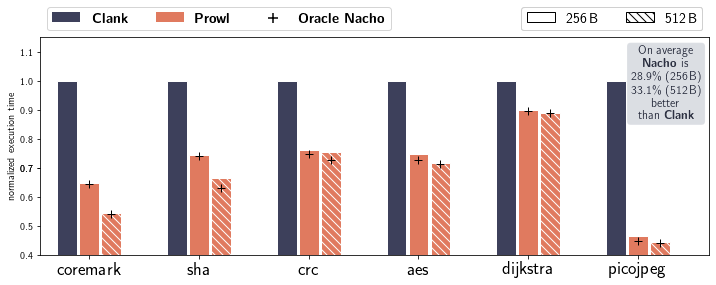

In [12]:
barsToPlot = {
                'config':['clank', 'nacho_pw'],
                'cache':['-256-4-', '-512-4-'],
                'bench':Benchmarks,
                'stats':['cycle'],
                'all_config':[('clank', '-256-2-'),
                            #   ('nacho_naive', '-256-2-'),
                            #   ('nachi-naive', '-512-2-'),
                            #   ('prowl', '-256-2-'),
                            #   ('prowl', '-512-2-'),
                              ('nacho_pw', '-256-4-'),
                              ('nacho_pw', '-512-4-'),]
            }

normalizeTo = "clank"

fig, ax = setupFigure(1, 1, figuresize=(12,4))
X = np.arange(len(Benchmarks))
stepSize = 1 / (len(barsToPlot['all_config']) + 2) 

gapThreshold = 1.15
gapStart = 1.12
ax.set_ylim(ymin=0.4, ymax=gapThreshold)
ax.set_xlim(-0.25,5.85);
ax.margins(x=0);
# ax.spines['right'].set_visible(False);
# ax.spines['top'].set_visible(False);
ax.set_xticks(X + stepSize * (len(barsToPlot['all_config']) - 1) / 2, Benchmarks, fontsize=18);
ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.7, 0.9, 0.8, 1.0, 1.1], fontsize=14)

step = 0
lineWidth = 0.1
clankDoneOnce = False;

# For each config
for cache in barsToPlot['cache']:

    # For different colors for configs
    idxCache = barsToPlot['cache'].index(cache)

    #for each cache
    for config in barsToPlot['config']:

        if config == 'clank':
            if clankDoneOnce is True:
                continue

            clankDoneOnce = True

        # For different colors for configs
        idxConfig = barsToPlot['config'].index(config)

        # The number of grouped plots are equal to the number of benchmarks
        toPlot = np.zeros(len(barsToPlot['bench']))
        
        # Get normalized value for the stats
        normalizedStat = fetchNormalizedValues(compiler, cache, normalizeTo, barsToPlot['stats'])

        # For each stack in the bar plot - stats
        for stats in barsToPlot['stats']:
            currStats = []

            # For different colors for stacked stats
            idxStat = barsToPlot['stats'].index(stats)
            
            # For each bmark
            for bench in barsToPlot['bench']:
                currStats.append(final_stats[compiler][cache][config][bench][stats])
            
            # Normalize the stats
            currStats = list(map(truediv, currStats, normalizedStat))

            # plot the stacked bar
            line = ax.bar(X + step,
                            currStats,
                            bottom = toPlot,
                            linewidth = 1,
                            joinstyle = 'miter',
                            hatch = patterns[idxCache] * 3,
                            color = ColorScheme[config],
                            alpha = 1,
                            edgecolor = 'white',
                            width = 4.5 * stepSize / 5)

            # increment the stack
            toPlot = toPlot + currStats

            if config == 'nacho_pw':
                markersToPlace = fetchNormalizedValues(compiler, cache, "nacho_clank", barsToPlot['stats'])
                markersToPlace = list(map(truediv, markersToPlace, normalizedStat))
                idx = 0
                for val in markersToPlace:
                    ann = plt.scatter(X[idx] + step, val, color='black',
                                      linewidths=1, marker="+", s=80)
                    idx = idx + 1

        # if config != 'clank':
        #     hLineForIdealCase = fetchNormalizedValues(cache, "nacho-clank", barsToPlot['stats'])
        #     hLineForIdealCase = list(map(truediv, hLineForIdealCase, normalizedStat))
        #     line = ax.bar(X + step,
        #                     hLineForIdealCase,
        #                     linewidth = 1,
        #                     joinstyle = 'miter',
        #                     color = 'white',
        #                     alpha = 0.4,
        #                     edgecolor = None,
        #                     width = 4.5 * stepSize / 5)

        # Separating each bmark
        step = step + stepSize

# Calculate the improvement percentages
prowlCycleValues = []
nachoCycleValues = []
meanImprovement = []
for cache in barsToPlot['cache']:
        prowlCycleValues = fetchNormalizedValues(compiler, cache, 'clank', ['cycle'])
        nachoCycleValues = fetchNormalizedValues(compiler, cache, 'nacho_pw', ['cycle'])
        diff = list(map(sub, prowlCycleValues, nachoCycleValues))
        diff = np.array(diff)
        diff = diff * 100 / np.array(prowlCycleValues)
        meanImprovement.append(diff.mean())

props = dict(boxstyle='round', facecolor=ColorName['Coral'], alpha=0.2, edgecolor='white')
text = "On average\n\\textbf{Nacho} is\n" + str(meanImprovement[0].round(1)) + "\% (256\,B)\n" + \
       str(meanImprovement[1].round(1)) + "\% (512\,B)\nbetter \nthan \\textbf{Clank}"

ann = plt.annotate(text,
                   xy=(5.455, 0.99), xytext=(0,0),
                   fontsize=12,
                   color=ColorName['Deep grey'],
                   horizontalalignment='center', verticalalignment='center',
                   xycoords=('data'), textcoords='offset points',
                   bbox=props,
                   annotation_clip=False)

# fig.add_artist(ann)

# For the legend
label1 = ['\\textbf{Clank}', '\\textbf{Prowl}','\\textbf{Oracle Nacho}']
label2 = ['256\\,B', '512\\,B']
label3 = ['Ideal Nacho']

n=[];
for i in barsToPlot['config']:
    n.append(ax.bar(0, 0, color=ColorScheme[i]))

n.append(plt.scatter(0, 0, color='black', linewidths=1.5, marker="+", s=120))
l1 = plt.legend(n, label1, loc='lower left', ncol=len(n),
                bbox_to_anchor = (0, 1), fancybox=True, fontsize=14);

ax.add_artist(l1)

n=[];
for i in range(len(barsToPlot['cache'])):
    n.append(ax.bar(0, 0, hatch=patterns[i]*3, color='white', edgecolor='black'))

l2 = plt.legend(n, label2, loc='lower right', ncol=len(n),
                bbox_to_anchor = (1, 1), fancybox=True, fontsize=14);

ax.add_artist(l2)

# n = [plt.scatter(0, 0, color=ColorName['Mandarin'], linewidths=3, marker="d")]
# l3 = plt.legend(n, label3, loc='upper right',
#                 bbox_to_anchor = (1.15, 0.68), fancybox=True, fontsize=14)


# ax.set_title("Execution time (CPU cycles) for different systems")
ax.set_ylabel("normalized execution time")
print();
fig.savefig('plots/execution-time-4-ways.pdf', bbox_inches='tight');